# TESS Data Workshop BLS Tutorial

## Getting Started

If you would like to get started with this tutorial, we recommend you have the following installed:

* `astropy` version 3.1 or higher (Python 3 compatible only)
* `lightkurve` version 1.0b26 or higher (use `pip install lightkurve --upgrade`)


## What is BLS?

The Box Least Squares (BLS) periodogram ([Kovacs et al. 2002](http://adsabs.harvard.edu/abs/2002A%26A...391..369K)) is a popular tool used for detecting transiting exoplanets in time series photometric data.  It works by fitting a box to phase-folded light curves, which is an operation that can be optimized significantly.

The most recent version of AstroPy (v3.1) features a fast and well-tested [implementation of BLS](http://docs.astropy.org/en/latest/stats/bls.html), which is what we will use here!


## Simple BLS Demo with Astropy

### Wait what's `lightkurve`?

`lightkurve` is the Kepler/K2 GO Office package to work with NASA Kepler, K2 and TESS data. There is another workshop for you to learn the ins and outs of `lightkurve`. 

In [6]:
import lightkurve as lk

In [76]:
# Download TOI 181 (TIC 76923707)
lcf = lk.search_lightcurvefile('TIC 12862099').download()

We've now downloaded a `LightCurveFile`, which is a fits file containing multiple extensions. We'll use the `PDCSAP_FLUX` extension. This is the pipeline processed light curve, and has been corrected for long term trends.

In [77]:
lcf

TessLightCurveFile(TICID: 12862099)

In [78]:
# Get a simple test light curve
lc = lcf.PDCSAP_FLUX.remove_nans()

We can take a look at the light curve we'll be using with the `plot`, `scatter` and `errorbar` methods in `lightkurve`.

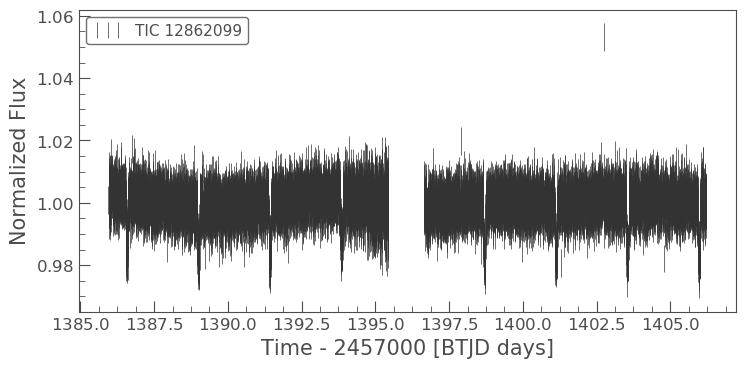

In [79]:
lc.errorbar();

This target has a long term trend, most likely due to star spot and stellar rotation. We can remove this long term trend with the `flatten` method. 

In [80]:
# Use the lightkurve flatten method
lc = lc.flatten(window_length=1701, break_tolerance=50)

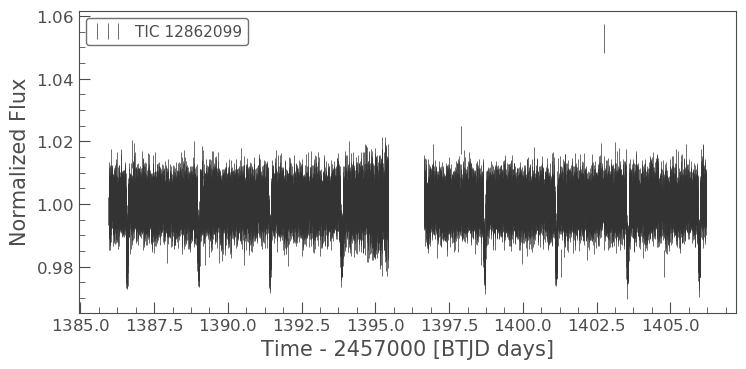

In [81]:
lc.errorbar();

Now that the light curve is flat, we can use the new `BoxLeastSquares` class from Astropy to search for transiting signals.

In [13]:
from astropy.stats import BoxLeastSquares
import numpy as np

In [82]:
# First, initialize a model 
model = BoxLeastSquares(lc.time, lc.flux, lc.flux_err)

# Find power at each period, for a range of durations
result = model.autopower(duration=0.05)

Now that we've calculated the power using the `autopower` function, let's look at the result.

In [83]:
result

          depth: array([9.58684332e-05, 7.17144103e-05, 7.40599676e-05, ...,
       1.57012292e-02, 1.55521372e-02, 1.57012292e-02])
      depth_err: array([7.80095089e-05, 7.79688680e-05, 7.79688548e-05, ...,
       7.40335436e-04, 7.40344796e-04, 7.40335436e-04])
      depth_snr: array([ 1.22893266,  0.91978263,  0.94986604, ..., 21.20826375,
       21.00661374, 21.20826375])
       duration: array([0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05])
 log_likelihood: array([  1.46302482,   0.84699938,   0.90317246, ..., 225.52230645,
       221.25410776, 225.52230645])
      objective: 'likelihood'
         period: array([ 0.1       ,  0.10000122,  0.10000244, ..., 10.10806675,
       10.12052209, 10.13300817])
          power: array([  1.46302482,   0.84699938,   0.90317246, ..., 225.52230645,
       221.25410776, 225.52230645])
   transit_time: array([0.02915261, 0.04227724, 0.02540146, ..., 0.95094148, 9.33762604,
       7.6170334 ])

The `result` object is a dictionary with the following keys

In [84]:
list(result.keys())

['objective',
 'period',
 'power',
 'depth',
 'depth_err',
 'duration',
 'transit_time',
 'depth_snr',
 'log_likelihood']

The period and the power where there is a good fit between the simple box model and the light curve. We can plot the periodogram easily

In [85]:
import matplotlib.pyplot as plt
plt.style.use(lk.MPLSTYLE) # Use a nice plotting style

Text(0, 0.5, 'Power')

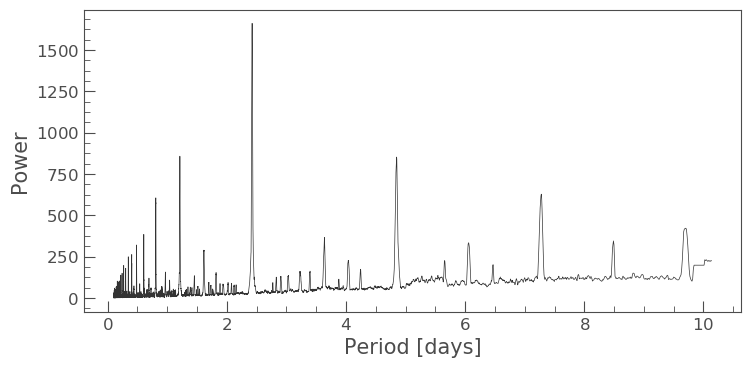

In [86]:
plt.plot(result.period, result.power);
plt.xlabel('Period [days]')
plt.ylabel('Power')

It looks like there is a strong periodicity around 5 days. Let's use the same tool to increase the period resolution around this region. Instead of using the `autopower` function, we can use the `power` function and pass our own array of periods. 

In [87]:
result = model.power(period=np.linspace(2, 3, 1000), duration=0.05)

Text(0, 0.5, 'Power')

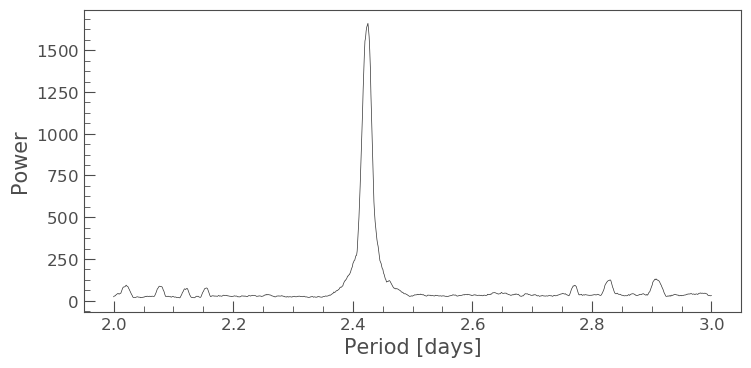

In [88]:
plt.plot(result.period, result.power);
plt.xlabel('Period [days]')
plt.ylabel('Power')

We can now find the period and transit midpoint at the peak of this distribution. This should be the period and transit midpoint that corresponds to the most significant fit between the box model and the light curve. 

In [89]:
period = result.period[np.argmax(result.power)]
t0 = result.transit_time[np.argmax(result.power)]
duration = result.duration[np.argmax(result.power)]

We can use Lightkurve's `fold()` method to fold the light curve and replot it

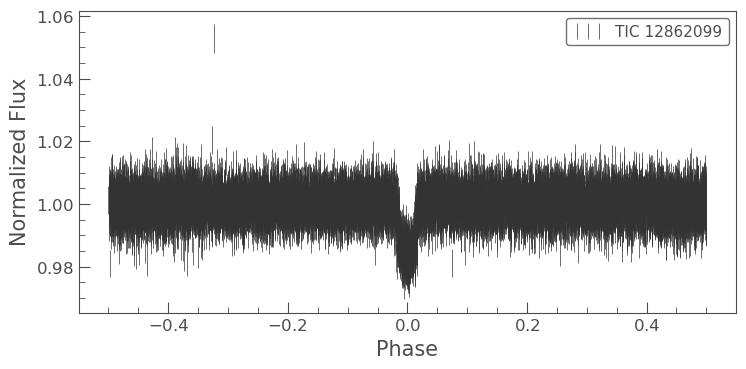

In [90]:
lc.fold(period, t0).errorbar();

We can also use Lightkurve's `bin()` method to average the points and look closer at the shape of the transit.

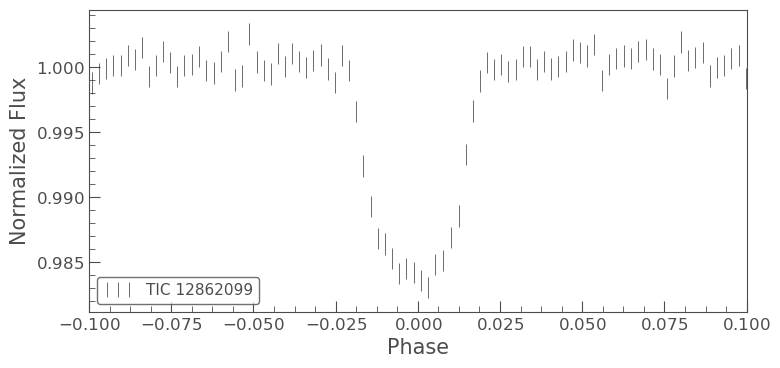

In [92]:
lc.fold(period, t0).bin(30).errorbar();
plt.xlim(-0.1, 0.1);

You can also use the BLS module to create a transit model, as demonstrated below:

In [93]:
model_flux = model.model(lc.time, period=period, duration=duration, transit_time=t0)
model_flux /= np.median(model_flux)

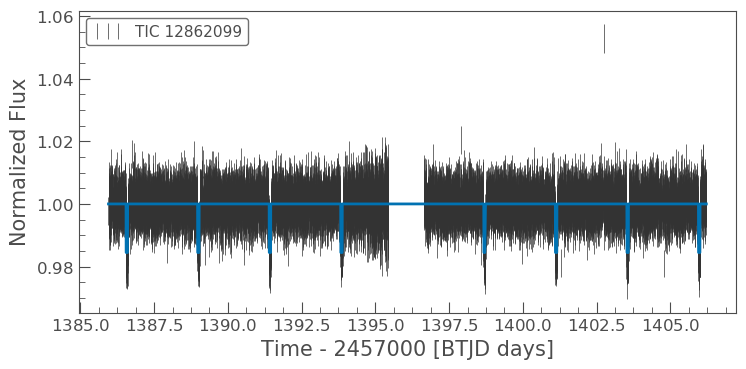

In [102]:
ax = lc.errorbar()
plt.plot(lc.time, model_flux, lw=2);

#  Compute Stats Demo

When we're vetting planets, a number of handy statistics can help inform us whether the transit signals are real. The `BoxLeastSquares.compute_stats()` allows us to access those stats very easily. Many of these statistics are based on the [VARTOOLS package](https://www.astro.princeton.edu/~jhartman/vartools.html) ([Hartman & Bakos 2016](https://arxiv.org/abs/1605.06811)).

In [103]:
stats = model.compute_stats(period=period, duration=duration, transit_time=t0)

Now we have created a dictionary called `stats` which contains statistics about our model fit. **Note: We have created this dictionary by passing the period, duration and transit midpoint that we would like to evaluate the statistics at.**

### Depth Statistics

The `stats` dictionary gives us access to the best fit depth of the period, duration and transit midpoint we passed.

In [105]:
stats['depth']

(0.015502969428016211, 0.000271825368594552)

This tuple contains the depth value, and the error on the depth value.

In [106]:
depth, depth_err = stats['depth']
print('Depth = {}% +/- {}'.format(np.round(depth*100, 4), np.round(depth_err*100, 4)))

Depth = 1.5503% +/- 0.0272


We also have acces to the depth for **odd** numbered transits, and the depth of **even** numbered tranits. 

In [107]:
odd_depth, odd_depth_err = stats['depth_odd']
print('Odd Depth = {}% +/- {}'.format(np.round(odd_depth*100, 4), np.round(odd_depth_err*100, 4)))

Odd Depth = 1.5532% +/- 0.0374


In [108]:
even_depth, even_depth_err = stats['depth_even']
print('Even Depth = {}% +/- {}'.format(np.round(even_depth*100, 4), np.round(even_depth_err*100, 4)))

Even Depth = 1.5471% +/- 0.0391


In [109]:
odd_even_difference = np.abs(even_depth - odd_depth) 
odd_even_error = (even_depth_err**2 + odd_depth_err**2)**0.5
sigma = odd_even_difference/odd_even_error

print('{:.3f} Sigma Detection of Odd/Even Depths being different'.format(sigma))

0.113 Sigma Detection of Odd/Even Depths being different


The `harmonic_delta_log_likelihood` is the difference in log likelihood between a sinusoidal model and the transit model. If `harmonic_delta_log_likelihood` is greater than zero, the sinusoidal model is preferred.

In [383]:
stats['harmonic_delta_log_likelihood']

-1542.5541075651145

In [389]:
stats['transit_times']

array([1386.57415261, 1388.99957803, 1391.42500346, 1393.85042888,
       1396.27585431, 1398.70127974, 1401.12670516, 1403.55213059,
       1405.97755601])

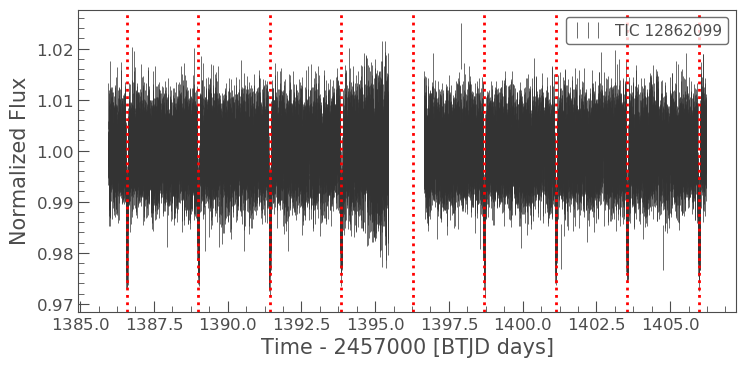

In [110]:
ax = lc.remove_outliers().errorbar()
for time in stats['transit_times']:
    ax.axvline(time, c='r', ls=':', lw=2)

# Finding TWO planets with masks

# BLS Demo with lightkurve

In [9]:
lc.interact_bls('http://localhost:8889')

# Alternative methods

* [Transit Least Squares (TLS)](https://github.com/hippke/tls)
* [Lomb-Scargle Periodogram](http://docs.astropy.org/en/stable/stats/lombscargle.html)